In [33]:
cd /home

/home


In [34]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os

from tensorflow.keras.optimizers import Adam
from src.record import load_records
from src.losses import reduce_std
from src.model import create_model

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
dataset = 'f_dhtau_low'
test_ds = load_records('./data/records/{}/fold_0/test'.format(dataset))

In [36]:
import pandas as pd
import os 
from tensorboard.backend.event_processing import event_accumulator
from tensorflow.core.util import event_pb2

def get_metrics(path_logs, metric_name='epoch_loss', full_logs=True, show_keys=False):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][-1]
    path_train = os.path.join(path_logs, train_logs)

    if full_logs:
        ea = event_accumulator.EventAccumulator(path_train, size_guidance={'tensors': 0})
    else:
        ea = event_accumulator.EventAccumulator(path_train)

    ea.Reload()

    if show_keys:
        print(ea.Tags())

    metrics = pd.DataFrame([(w,s,tf.make_ndarray(t))for w,s,t in ea.Tensors(metric_name)],
                columns=['wall_time', 'step', 'value'])
    return metrics

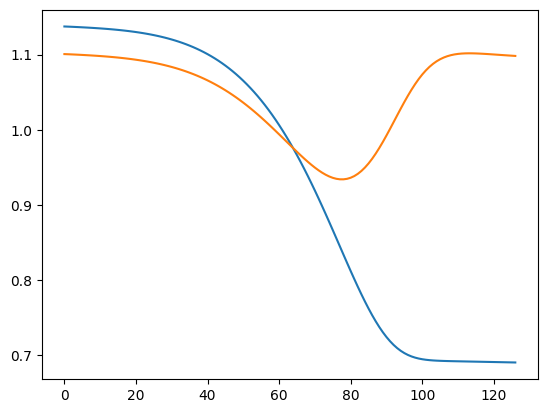

In [37]:
logs_train = get_metrics('./logs/test_{}/logs/train/'.format(dataset))
logs_val = get_metrics('./logs/test_{}/logs/validation/'.format(dataset))

plt.plot(logs_train['value'], label='training')
plt.plot(logs_val['value'], label='validation')
plt.show()

In [38]:
window_size = 50
model = create_model(window_size=window_size)
model.load_weights('./logs/test_{}/weigths'.format(dataset))

In [39]:
optimizer = Adam(1e-3)
model.compile(loss_fn=reduce_std)

In [40]:
# model.summary()

In [41]:
model.evaluate(test_ds)

3/3 [==============================] - 1s 49ms/step - loss: 0.8811


0.8693731427192688

In [42]:
flux_pred = model.predict(test_ds)

3/3 [==============================] - 1s 43ms/step


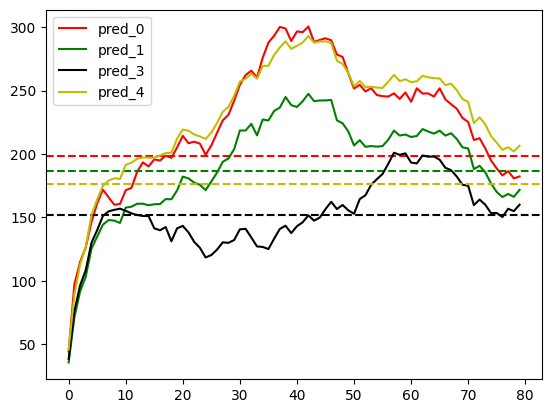

In [57]:
true_df = pd.read_csv('./data/records/{}/fold_0/test/true_values.csv'.format(dataset))

colorlist=['r', 'g', 'b', 'k', 'y']
for f, (i, row) in zip(flux_pred, true_df.iterrows()):
    if np.mean(f) > 1000: continue
    plt.plot(f, label='pred_{}'.format(i), color=colorlist[i])
    plt.axhline(y=row['true_flux'], color=colorlist[i], linestyle='--')

plt.legend()

In [52]:
tf.reduce_mean(flux_pred, axis=1)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 224.53711],
       [ 191.17285],
       [1145.4645 ],
       [ 151.91354],
       [ 230.51254]], dtype=float32)>

In [53]:
true_df['true_flux']

0    198.184462
1    186.526357
2     82.131321
3    152.210144
4    176.327180
Name: true_flux, dtype: float64